## Get the outputs

Lab41 trained a DenseCap model using Visual Genome's (hereafter VG) object tags. We ran the model on the ESP-Game test images (hereafter ESP) to evaluate X-corpus.

Notes: A GloVe word vector model was used for translating words in VG's vocabulary, but not in ESP's vocabulary, to ESP's vocabulary. To do the translation between predicted words not in ESP's vocabulary to a single ESP word, the highest correlated value (according to the dot product of the GloVe model vectors) of that predicted word with an ESP word was chosen.

In [1]:
import sys
sys.path.append("attalos/")
from attalos.evaluation.evaluation import Evaluation
from oct2py import octave
octave.addpath('attalos/attalos/evaluation/')
import json
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from IPython.core.display import display
from IPython.core.pylabtools import figsize
from scripts import load_combine_json_dir, print_list_to_columns

In [2]:
jsondir = "/data/fs4/datasets/espgame/ESP-ImageSet"
imgdir = "/data/fs4/datasets/espgame/ESP-ImageSet/test_images"
wordvecs_dir = "/data/fs4/teams/attalos/wordvecs"

In [3]:
with open(os.path.join(jsondir,"esp_test_imageset_tags_predictions.json")) as jdata:
    predicts = json.load(jdata)

with open(os.path.join(jsondir,"esp_test_imageset_tags.json")) as jdata:
    truthdicts = json.load(jdata)

## Visual Inspection

We need to make sure these predictions and ground truth values make sense. Below we display an image along with it's ground truth and predicted VG vocabulary detections.

32293.jpg


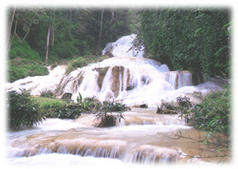

**************************************************
Ground Truth labels:

forest  grass   green   river   
rock    tree    water   
**************************************************
Predicted labels:

hill   rock   dog    head   sheep  
snow   trees  dog    head   grass  


In [4]:
fname = np.random.choice(predicts.keys())
print fname
truthlbls = truthdicts[fname]
predlbls = predicts[fname]

img = Image.open(os.path.join(imgdir, fname))
display(img)

print("*" * 50 + "\nGround Truth labels:\n")
print_list_to_columns(truthlbls)

print("*" * 50 + "\nPredicted labels:\n")
print_list_to_columns(predlbls[0:10],items_per_row=6)

## Get GloVe vectors

The GloVe vector file is structure: each line is a vector for one word with the word as the first part of the line. Each element of the line is sperated with a space. One line examples: "dog 2.342 1.233 2.454"

In [5]:
glove_vector_file = os.path.join(wordvecs_dir, "glove.6B.200d.txt")

In [6]:
f=open(glove_vector_file,'r')

glove_vec_dic = {}
for i in f.read().splitlines():
    t=i.split()
    tv=[]
    for j in t[1:]:
        tv.append(float(j))
    glove_vec_dic[t[0]]=tv

f.close()

## Get ESP vocab vectors

Gather all of the words in ESP vocabulary and then create a matrix with the word vectors (from the GloVe model) of the ESP vocabulary. All ESP words are in the GloVe model

In [7]:
esp_dir = "/data/fs4/datasets/espgame"
data = np.load(os.path.join(esp_dir,"espgame-inria.npz"))
esp_vocab = data["D"] # ESP vocabulary
yTe = data ["yTe"] # ESP onehot matrix
testlist = data['testlist'] # ESP test images

In [8]:
esp_vocab_vec = np.zeros((len(esp_vocab),len(glove_vec_dic.values()[0])))

In [9]:
for i in range(len(esp_vocab)):
    esp_vocab_vec[i]=glove_vec_dic[esp_vocab[i]]

## Get VisualGenome vocab vectors

Gather all of the words in VG vocabulary and then create a matrix with the word vectors (from the GloVe model) of the VG vocabulary. Note: 134 out of 4688 VG words not in the GloVe model. These words are in the VG word vector matrix with 0's.

In [10]:
with open("/data/fs4/home/justinm/andrew-attalos/andreww/VG-object-regions-dicts.json.txt") as jdata:
    vgg_json_vocab = json.load(jdata)

vgg_vocab=[]
for i in vgg_json_vocab['token_to_idx'].keys():
    vgg_vocab.append(str(i))


In [11]:
temp_vgg_vocab = []
for i in vgg_vocab:
    if i in glove_vec_dic.keys():
        temp_vgg_vocab.append(i)
    #if i % 500 == 0:
    #    print i, ' out of ', len(vgg_vocab)
vgg_vocab_not_in_glove = list(set(vgg_vocab)-set(temp_vgg_vocab))[:]

In [12]:
vgg_vocab_vec = np.zeros((len(vgg_vocab),len(glove_vec_dic.values()[0])))
print len(vgg_vocab)
print len(temp_vgg_vocab)
print len(vgg_vocab)-len(temp_vgg_vocab)
print vgg_vocab_vec.shape

4688
4554
134
(4688, 200)


In [13]:
for i in range(len(vgg_vocab)):
    if vgg_vocab[i] in vgg_vocab_not_in_glove:
        vgg_vocab_vec[i,:]=0
    else:
        vgg_vocab_vec[i]=glove_vec_dic[vgg_vocab[i]]

## Do some comparison between ESP, VisualGenome, and GloVe vocab

14 ESP words not in VG vocabulary and was 1.7% (167 out of 9774 tags) of the total number of tags in ESP's test images


In [14]:
esp_not_in_glove = []
esp_not_in_vgg = []
for i in esp_vocab:
    if i not in vgg_vocab:
        esp_not_in_vgg.append(i)
        print i, " not in VG vocab"
    if i not in glove_vec_dic.keys():
        esp_not_in_glove.append(i)
        print "\t",i, " not in GloVe"

anime  not in VG vocab
click  not in VG vocab
com  not in VG vocab
dance  not in VG vocab
diagram  not in VG vocab
fight  not in VG vocab
graph  not in VG vocab
insect  not in VG vocab
internet  not in VG vocab
online  not in VG vocab
planet  not in VG vocab
singer  not in VG vocab
sketch  not in VG vocab
war  not in VG vocab


In [15]:
# Get the word not in VG and index of the image in testlist
esp_gt_not_in_vgg={}
for i in esp_not_in_vgg:
    idxword = np.argwhere(esp_vocab==i)
    idxsimg = np.nonzero(yTe[:,idxword])[0]
    if len(idxsimg) != 0:
        esp_gt_not_in_vgg[i] = idxsimg

In [16]:
# print ESP word not in VG and the image index
for i in esp_gt_not_in_vgg.keys():
    print i, esp_gt_not_in_vgg[i]

planet [ 209  416  760 1071 1199 1768]
singer [ 265  808  995 1062 1109 1444 1700 1732 1800]
war [  14   57  151  204  208  349  432  535  716  915 1191 1263 1308 1386]
dance [ 135  250  460  518  557  681  682  683  685  686  688  781  869 1063 1373
 1374 1569]
graph [  66   68   69   70  116  247  274  406  757  829  883  885  948  949 1002
 1017 1150 1151 1237 1477 1644 1645 1671 1717 1794 1817 1858 1897 1936 1954
 1978 2001 2034]
online [ 742 1152 1183 1228 1890 1931 1959]
sketch [  70 1472 1709]
fight [   9  208  349  518  754  792 1088 1132 1437 1630 1787]
diagram [  87  117  141  247  305  473  482  588  720  883  885  988 1002 1024 1108
 1409 1472 1499 1637 1644 1645 1648 1936 1953 2001]
insect [  25  160  917 1064 1128 1287 1288 1322 1323 1324 1325 1479 1585 1921]
anime [  92  399  582  736  841  850 1605 1977]
internet [  95  398  775 1235]
com [  86 1089 1196 1548 1665]
click [ 105  753 1051 1362 1439 1497 1718 1822 1901 1911 2017]


In [17]:
# print words in VG but not in ESP
vgg_vocab_not_in_glove = list(set(vgg_vocab)-set(temp_vgg_vocab))[:]
print len(vgg_vocab_not_in_glove), " words in VG but not in GloVe"
print vgg_vocab_not_in_glove

134  words in VG but not in GloVe
['cous', 'windsheild', 'girraffe', 'earing', 'surboard', 'lampost', 'skii', 'doubledecker', 'serviette', 'kneepad', 'ossicones', 'tounge', 'groud', 'bouy', 'girafee', 'matress', 'mountian', 'winshield', 'brocolli', 'whispy', 'dalmation', 'treee', 'surfboarder', 'flipflop', 'postit', 'corndog', 'brakelight', 'skort', 'sanwich', 'snowpants', 'lightswitch', 'trashbin', 'sidwalk', 'ligh', 'trashbag', 'unbrella', 'palmtree', 'hairband', 'freesbee', 'snowcovered', 'woma', 'fencepost', 'lightpost', 'tarmack', 'barette', 'buildig', 'barefeet', 'upest', 'tailight', 'dougnut', 'sideburn', 'ossicone', 'numberal', 'faceguard', 'bannana', 'traintracks', 'controler', 'buiding', 'bedskirt', 'parasailer', 'sandwhich', 'bathmat', 'baloon', 'girrafe', 'selfie', 'tanktop', 'broccolli', 'treetrunk', 'shinguard', '<UNK>', 'sideview', 'scrunchie', 'streetsign', 'teddybear', 'toiletpaper', 'skipole', 'lable', 'brocoli', 'tomatos', 'gogget', 'foilage', 'sandle', 'cieling', 'w

## Get Correlation matrix of ESP vocab vectros with VisualGenome word vectors

In [18]:
# convert ESP word vectors to unit vectors
esp_vocab_vec_norm = np.divide(esp_vocab_vec.T,np.linalg.norm(esp_vocab_vec,axis=1)).T

In [19]:
# convert VG word vectors to unit vectors. Do to the VG words not in GloVe, those vectors have length 0.

vgg_norm = np.linalg.norm(vgg_vocab_vec,axis=1)
vgg_vocab_vec_norm = vgg_vocab_vec.copy()

# Have to convert each word vector one at a time do to some word vector lengths of 0
for i in xrange(len(vgg_norm)):
    if vgg_norm[i] != 0:
        vgg_vocab_vec_norm[i] = np.divide(vgg_vocab_vec[i],vgg_norm[i])

In [20]:
# create the correlation matrix between the ESP word vectors and VG word Vectors
esp_vgg_corr = np.dot(esp_vocab_vec_norm,vgg_vocab_vec_norm.T)

In [21]:
# Testing the correlation of the same word has dot product of 1
print 'airplane' in esp_vocab
print 'airplane' in vgg_vocab
print esp_vgg_corr[np.argwhere(esp_vocab==('airplane'))[0][0],vgg_vocab.index('airplane')]

True
True
1.0


In [22]:
# reduce predicted tags to the top 5 without repetitive words and <UNK> tokens
# the predicted tags are in order from most confidence to least
reduced_predicts={}
top_n_words = 5
lessthan5 = 0
print "number of test images = ",len(predicts.keys())
for i in predicts.keys():
    words = predicts[i]
    newl = [] # new list of top n predicted words 
    norepeats = [] # complete list of words without repeated words and <UNK> tokens
    for j in words:
        if len(newl) >= top_n_words and j not in norepeats:
            norepeats.append(j)
        elif j != "<UNK>" and j not in newl:# and j in vocab:
            newl.append(j)
            norepeats.append(j)
    reduced_predicts[i] = newl
    if len(newl) < top_n_words:
        lessthan5+=1
        #print newl, len(newl)
        #print norepeats
print lessthan5, "/", len(predicts.keys()), " have less than 5 predicted words that are in the ESP-Games dictionay"

number of test images =  2081
5 / 2081  have less than 5 predicted words that are in the ESP-Games dictionay


In [23]:
# list predicted tags that are not in ESP vocab
no_pred_words_in_esp_dict = {}
no_pred_words_in_glv_dict = {}
for i in reduced_predicts.keys():
    no_pred_words_in_esp = []
    no_pred_words_in_glv = []
    for j in reduced_predicts[i]:
        if str(j) not in esp_vocab:
            no_pred_words_in_esp.append(j)
        if str(j) in vgg_vocab_not_in_glove:
            no_pred_words_in_glv.append(j)
    if len(no_pred_words_in_esp)>0:
        no_pred_words_in_esp_dict[i] = no_pred_words_in_esp
        print i,no_pred_words_in_esp," predictions not in esp vocab"
    if len(no_pred_words_in_glv)>0:
        no_pred_words_in_glv_dict[i] = no_pred_words_in_esp
        print i,no_pred_words_in_glv," predictions not in GloVe dictionary"

#print len(no_pred_words_in_esp_dict.keys())," number of images that have a top 5 tag not in esp vocab"
#print len(no_pred_words_in_glv_dict.keys())," number of images that have a top 5 tag not in glove dictionary"

63254.jpg [u'clock', u'racket']  predictions not in esp vocab
109399.jpg [u'umbrella', u'sidewalk', u'shorts', u'name']  predictions not in esp vocab
136417.jpg [u'sheep', u'leg', u'neck']  predictions not in esp vocab
75761.jpg [u'vase', u'clock', u'graffiti', u'shelf', u'bread']  predictions not in esp vocab
215943.jpg [u'pizza', u'neck']  predictions not in esp vocab
74817.jpg [u'cockpit', u'wheels', u'ground', u'runway', u'trees']  predictions not in esp vocab
20893.jpg [u'motorcycle', u'pants', u'engine', u'suitcase', u'leg', u'skateboard', u'seat']  predictions not in esp vocab
21586.jpg [u'pants']  predictions not in esp vocab
42105.jpg [u'fruit']  predictions not in esp vocab
79268.jpg [u'wire', u'wires', u'lamp', u'cord', u'kite', u'chain', u'branch']  predictions not in esp vocab
52110.jpg [u'pants', u'racket', u'cow', u'curtain', u'leg']  predictions not in esp vocab
26366.jpg [u'cockpit', u'ground', u'gear', u'name']  predictions not in esp vocab
48766.jpg [u'bus', u'leg'] 

In [24]:
# Create onehot matrix of predicted tags. 
# Also translating VG words not in ESP vocab to the highest correlated word in ESP vocab
predict_arr = np.zeros(yTe.shape,dtype=np.int)
x_corpa_word_map={} # image as key, value is [VG word, correlated ESP word, dot product of words]
for i in reduced_predicts.keys():
    idximg = np.argwhere(testlist==i)[0][0]
    for j in reduced_predicts[i]:
        wordmap=[]
        idxwrd = np.argmax(esp_vgg_corr[:,vgg_vocab.index(j)])
        predict_arr[idximg,idxwrd] = 1
        if str(j) != esp_vocab[idxwrd]:
            wordmap.append([str(j),
                            esp_vocab[idxwrd],
                            esp_vgg_corr[np.argmax(esp_vgg_corr[:,vgg_vocab.index(j)]),vgg_vocab.index(j)]])
        if esp_vgg_corr[np.argmax(esp_vgg_corr[:,vgg_vocab.index(j)]),vgg_vocab.index(j)] == 0:
            print 'help, vg word has no correlation with a word in ESP \t',wordmap[-1] # fortunatelly this did not happen
    if len(wordmap) != 0:
        x_corpa_word_map[i]=wordmap

In [25]:
# Reduce repeated word correlations
reduced_x_corpa_word_map = []
for i in x_corpa_word_map.keys():
    for j in x_corpa_word_map[i]:
        if j not in reduced_x_corpa_word_map:
            reduced_x_corpa_word_map.append(j)
print len(reduced_x_corpa_word_map), "VG words had to be correlated to an ESP word"

125 VG words had to be correlated to an ESP word


In [26]:
# print the mapping from VG word to the highest correlated ESP word
print "[predicted word in vg, word with highest correlation to esp word, correlation]"
for i in reduced_x_corpa_word_map[:]:
    print i

[predicted word in vg, word with highest correlation to esp word, correlation]
['name', 'word', 0.707352439867172]
['bread', 'food', 0.5474538844588972]
['base', 'field', 0.50708689214727387]
['leg', 'legs', 0.6954942224349886]
['rug', 'floor', 0.3393269738217996]
['neck', 'legs', 0.61754647420848308]
['graffiti', 'poster', 0.50344610443692772]
['court', 'suit', 0.54084151941274994]
['shoe', 'shoes', 0.75366735437716459]
['ski', 'mountain', 0.60707525022470821]
['leaves', 'leaf', 0.60270149397573969]
['ground', 'field', 0.52466084086514986]
['collar', 'black', 0.50004146473360445]
['pillow', 'bed', 0.50205609700384757]
['trees', 'tree', 0.84778429182777792]
['bush', 'white', 0.54481009101885725]
['bowl', 'game', 0.49413327453599115]
['letters', 'letter', 0.81600223839420494]
['vent', 'roof', 0.34392689252911268]
['stripe', 'stripes', 0.67681062432860029]
['edge', 'point', 0.55539942631870098]
['cord', 'ear', 0.40451778656232218]
['pants', 'jacket', 0.76674739478006315]
['whiskers', 'be

In [27]:
# print ESP word not in VG and the image index
num_tags_not_vgg_in_esp_gt = 0
for i in esp_gt_not_in_vgg.keys():
    print i, esp_gt_not_in_vgg[i]
    num_tags_not_vgg_in_esp_gt += len(esp_gt_not_in_vgg[i])

print num_tags_not_vgg_in_esp_gt, " number of times an ESP word not in VG but was used in the ESP test images"
print np.sum(yTe), " number of ESP ground truth tags"
print num_tags_not_vgg_in_esp_gt/np.sum(yTe) * 100, "%"

planet [ 209  416  760 1071 1199 1768]
singer [ 265  808  995 1062 1109 1444 1700 1732 1800]
war [  14   57  151  204  208  349  432  535  716  915 1191 1263 1308 1386]
dance [ 135  250  460  518  557  681  682  683  685  686  688  781  869 1063 1373
 1374 1569]
graph [  66   68   69   70  116  247  274  406  757  829  883  885  948  949 1002
 1017 1150 1151 1237 1477 1644 1645 1671 1717 1794 1817 1858 1897 1936 1954
 1978 2001 2034]
online [ 742 1152 1183 1228 1890 1931 1959]
sketch [  70 1472 1709]
fight [   9  208  349  518  754  792 1088 1132 1437 1630 1787]
diagram [  87  117  141  247  305  473  482  588  720  883  885  988 1002 1024 1108
 1409 1472 1499 1637 1644 1645 1648 1936 1953 2001]
insect [  25  160  917 1064 1128 1287 1288 1322 1323 1324 1325 1479 1585 1921]
anime [  92  399  582  736  841  850 1605 1977]
internet [  95  398  775 1235]
com [  86 1089 1196 1548 1665]
click [ 105  753 1051 1362 1439 1497 1718 1822 1901 1911 2017]
167  number of times an ESP word not in VG 

## Running the evaluation code

In [28]:
# Evaluate the ground truth tags (yTe) to the top n predicted tags (predict_arr)
[precision,recall,f1] = octave.evaluate(yTe.T, predict_arr.T, 5)
print("Precision: {0:0.3f}".format(precision))
print("Recall: {0:0.3f}".format(recall))
print("F-1: {0:0.3f}".format(f1))

Precision: 0.058
Recall: 0.087
F-1: 0.070


These performance metrics reults are not very good and are not representative of the model's performance judging from visual inspection of a small sample. To overcome this, we'll look at a simplified version of the metrics. For precision, we'll divid the size of the intersection over the size of the union. 

$$\text{precision} = \frac{|\{\text{test}\} \cap \{\text{predicted}\}|}{|\{\text{test}\} \cup \{\text{predicted}\}|}$$

Recall evaluates the correctly predicted labels over the set of all correct labels. Since a false negative here is the absence of a predicted label and a false positive is the addition of a label we'll look at the size of the intersection of the actual and predicted over the size of the actual labels for each.

$$\text{recall} = \frac{|\{\text{test}\} \cap \{\text{predicted}\}|}{|\{\text{test}\}|}$$

And finally the F-1 score

$$\text{f1} = 2 \cdot \frac{(\text{precision} \cdot\text{recall})}{(\text{precision} + \text{recall})}$$

In [29]:

intersection = 0
union = 0
recall_denom = 0
'''
for fname in gt_set.iterkeys():
    a = gt_set[fname]
    b = prediction_set[fname]
    intersection += len(a.intersection(b))
    union += len(a.union(b))
    recall_denom += len(a)
'''

################################################

for fname in truthdicts.keys():
    a = set(truthdicts[fname])
    b = set(reduced_predicts[fname])
    intersection += len(a.intersection(b))
    union += len(a.union(b))
    recall_denom += len(a)

intersection=float(intersection)

###############################################

precision = intersection / union
recall = intersection / recall_denom
f1 = 2 * (precision * recall) / (precision + recall)
print("Precision: {0:0.3f}".format(precision))
print("Recall: {0:0.3f}".format(recall))
print("F-1: {0:0.3f}".format(f1))

Precision: 0.075
Recall: 0.283
F-1: 0.118
